# Rossmann Store Sales

Rossmann is one of the largest drugstore chains in Germany, with operations across Europe. As of 2018, they have well over 3,900 stores in Europe with an annual turnover of 9 billion euros. 
### Our task is to predict the sales for a few identified stores on a given day.

We are going to develop an ML model that can learn the sales for a store as a function of internal, external, and temporal (time-based) attributes and then predict future sales given the attributes available.

## Problem Statement 

<img src="problem-statement.png">

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
df  = pd.read_csv("train.csv")

In [4]:
print("Shape of the Dataset:",df.shape)
#the head method displays the first 5 rows of the data
df.head()

Shape of the Dataset: (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
store  = pd.read_csv("store.csv")
print("Shape of the Dataset:",store.shape)

#Display the first 5 rows of data using the head method of pandas dataframe
store.head(5)

Shape of the Dataset: (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Metadata (Data Dictionary)
* Store - a unique Id for each store
* Sales - the turnover for a given day (Our target y variable)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

To have all the data points together, we need to create one single dataframe with the store and promotion features. We can  achieve this by joining the two dataframes on the ‘store’ column, which represents the store ID

In [6]:
df_new = df.merge(store,on=["Store"], how="inner")
print(df_new.shape)

(1017209, 18)


In [7]:
df_new.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## Exploring Dataset

In [8]:
#How many stores do we have the data for?
print("Distinct number of Stores :", len(df_new["Store"].unique()))

#How long do we have the data for?
print("Distinct number of Days :", len(df_new["Date"].unique()))

#What do the average sales for a day look like?
print("Average daily sales of all stores : ",round(df_new["Sales"].mean(),2))

Distinct number of Stores : 1115
Distinct number of Days : 942
Average daily sales of all stores :  5773.82


## Finding Data Types

In [9]:
df_new.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

## Working with Time

In [12]:
df_new["DayOfWeek"].value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

* We can see seven distinct values, with similar numbers of records in each, for the “day of the week” feature. 
* Given that we already have the date as a feature, we could have directly used the date column to create the day of the week and also create a few other features.

* Let’s create additional features that will help our model learn patterns better. 
* We will create the week number, month, day, quarter, and year as features from the date variable. 
* Similarly, since we are already creating time-related features, we can add a new feature based on climate and seasons. 
* Considering that the stores are in Europe, we can refer to the standard season cycles and create a new season feature with values of Spring, Summer, Fall, and Winter. 


In [13]:
df_new["Date"] = pd.to_datetime(df_new["Date"])
df_new["Month"] = df_new["Date"].dt.month
df_new["Quarter"] = df_new["Date"].dt.quarter
df_new["Year"] = df_new["Date"].dt.year
df_new["Day"] = df_new["Date"].dt.day
df_new["Week"] = df_new["Date"].dt.week

df_new["Season"] = np.where(df_new["Month"].isin([3,4,5]),"Spring",
                        np.where(df_new["Month"].isin([6,7,8]),"Summer",
                            np.where(df_new["Month"].isin([9,10,11]),"Fall",
                                np.where(df_new["Month"].isin([12,1,2]),"Winter","None"))))


In [14]:
#Using the head command to view (only) the data and the newly engineered features
print(df_new[["Date","Year","Month","Day","Week","Quarter","Season"]].head())

        Date  Year  Month  Day  Week  Quarter  Season
0 2015-07-31  2015      7   31    31        3  Summer
1 2015-07-30  2015      7   30    31        3  Summer
2 2015-07-29  2015      7   29    31        3  Summer
3 2015-07-28  2015      7   28    31        3  Summer
4 2015-07-27  2015      7   27    31        3  Summer


## Predicting Sales

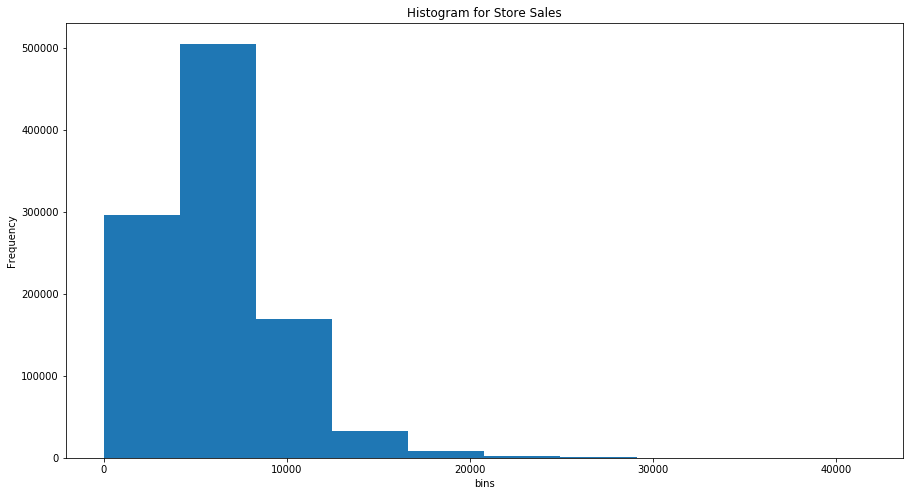

In [16]:
#Import matplotlib, python most popular data visualizing library
import matplotlib.pyplot as plt
%matplotlib inline

#Create a histogram to study the Daily Sales for the stores
plt.figure(figsize=(15,8)) 
plt.hist(df_new["Sales"])  
plt.title("Histogram for Store Sales")
plt.xlabel("bins")
plt.ylabel("Frequency")
plt.show()

* The histogram helps us understand the distribution of the data at a high level. 
* From the preceding plot, we can see that the data range is from 0 to 40,000, but there is barely any data after 20,000. 
* This indicates that most of the stores have sales in the range 0–20,000.
* Just a few stores have sales greater than 20,000. 
* It might be worthwhile to remove these outliers, as it helps the model learn better.

## Exploring Numeric Columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E5205BF978>,
      dtype=object)

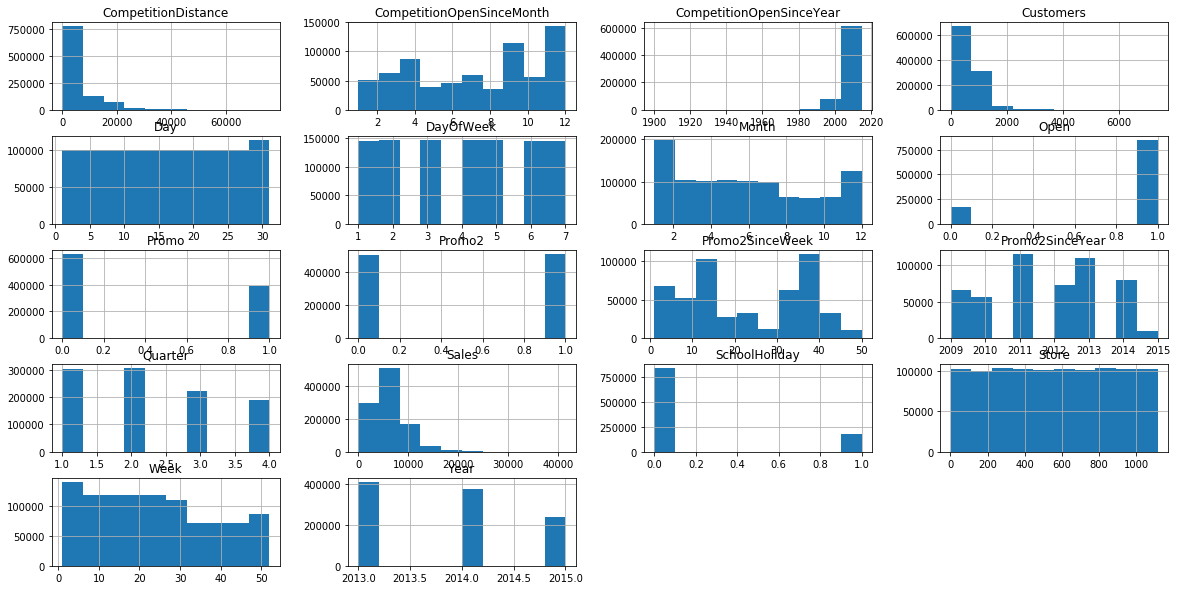

In [17]:
#Use the  histogram function provided by the Pandas object
#The function returns a cross-tab histogram plot for all numeric columns in the data
df_new.hist(figsize=(20,10))

### Analysis from the Histogram

* We can see that the features Promo, Promo2, School Holiday, and Open are actually binary categorical features: they represent two possible values similar to gender: Male or Female. Therefore, these are actually categorical features but already encoded as numeric columns. we won’t need to further process them, as DL models understand only numeric values.
* Promo2 is well distributed between the two distinct values.
* Promo has more records for ‘1’ and Open has most of the store records as ‘1’. 
* The distribution between the values for ‘Open’ makes sense, as the stores will be open for most days except state holidays.

* Customer numbers range from 0 to 2,000 for most stores. A few stores have as many as 7000 daily customers, but these are outliers and we mightneed to fix them before modeling.

* The next set of numeric variables are Promo2SinceWeek and Promo2SinceYear; these show a relatively well-distributed feature.
* The rest of the histograms are pretty much self-explanatory.

### Checking missing data in dataset

In [18]:
df_new.isnull().sum()/df_new.shape[0] * 100

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
Month                         0.000000
Quarter                       0.000000
Year                          0.000000
Day                           0.000000
Week                          0.000000
Season                        0.000000
dtype: float64

* We can see that Promo2SinceWeek, Promo2SinceYear, PromoInterval, CompetitionOpenSinceMonth, and CompetitionOpenSinceYear have over 30% null values. 
* This is a big loss and there is nothing much we can do to fix this. 
* As a rule of thumb, if there is a loss of anything between 0% and 10%, we can make a few  attempts to fill the missing points and use the feature. 
* But, 30% technically becomes beyond the usable range. On the other hand, we can see CompetitionDistance has around 0.25% missing values. This would much easier to handle and fix.

In [19]:
#Replace nulls with the mode
df_new["CompetitionDistance"]= df_new["CompetitionDistance"].fillna(df_new["CompetitionDistance"].mode()[0])

In [20]:
#Double check if we still see nulls for the column
df_new["CompetitionDistance"].isnull().sum()/df_new.shape[0] * 100

0.0

## Understanding the Categorical Features

* We have StoreType, Assortment, and the newly created Season feature as the categorical features. 
* Though ‘Open’, ‘Promo’, ‘Promo2’, and so on are binary categorical variables, they have been stored as numeric values.
* The best way to study a categorical variable is to study the impact on the target variable from its individual classes. We can do this by plotting the mean sales across different values of the classes in the feature.

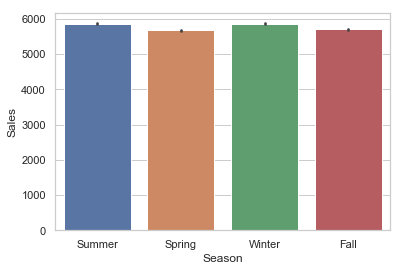

In [21]:
import seaborn as sns  #Seaborn is another powerful visulization library for Python
sns.set(style="whitegrid")

#Create the bar plot for Average Sales acrss different Seasons
ax = sns.barplot(x="Season", y="Sales", data=df_new)

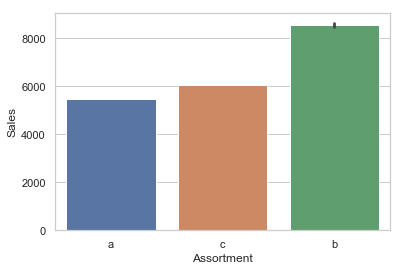

In [22]:
#Create the bar plot for Average Sales acrss different Assortments
ax = sns.barplot(x="Assortment", y="Sales", data=df_new)

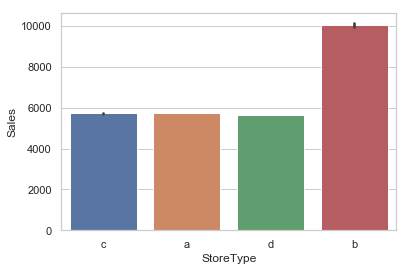

In [23]:
#Create the bar plot for Average Sales acrss different Store Types
ax = sns.barplot(x="StoreType", y="Sales", data=df_new)

#### What if the number of stores in the different types mentioned in the preceding is disproportionate or skewed?
In such a scenario, our observation might be flawed. To cement our understanding about the observation, we can simply check the number of data points across each category using the same barplot function with one additional parameter setting.

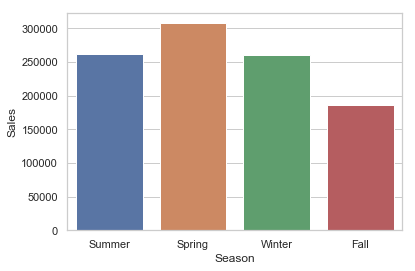

In [24]:
ax = sns.barplot(x="Season", y="Sales", data=df_new,estimator=np.size)

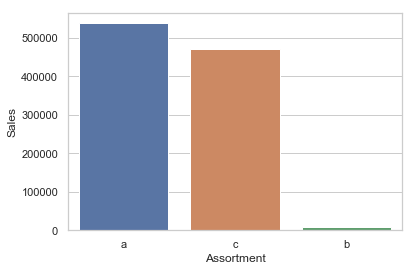

In [25]:
ax = sns.barplot(x="Assortment", y="Sales", data=df_new,estimator=np.size)

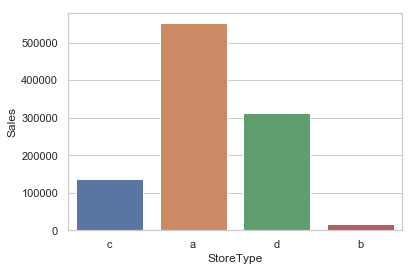

In [26]:
ax = sns.barplot(x="StoreType", y="Sales", data=df_new,estimator=np.size)

## Data Engineering

* As already mentioned, DL models understand only numeric data.
* Therefore, all categorical features stored as text columns need to be converted to a one-hot encoded form for the model training data.

* One-hot encoding is a simple process of representing a categorical column as an expanded binary labeled matrix. 
* So, a categorical feature with three distinct values, say “Class A,” “Class B,” and “Class C,” can be represented with three columns instead of one, where each column would represent a binary flag for an individual category value.

<img src="one-hot-encoding.png">

* In our dataset, we have three categorical variables that need transformation; they are Season, Store Type, and Assortment.

* In the context of categorical variables, the day of the week, month, day, quarter, and in fact the store ID can also be defined as categorical. 

* These features have a definite number of distinct classes; 
    * the day of the week can be a value only between 1 and 7. Representing them as just a column with a number might be a bad idea in cases where there are significant differences expected on different classes. 
    * For example, sales on Sunday and Monday are completely different, but internally if Sunday = 0 and Monday = 1, Tuesday = 2 and so on, a step increase from Sunday to Monday is not the same as a step increase from Monday to Tuesday. In that context, it is a good practice to represent a categorical column in its one-hot encoded version. 
    
#####  But where do we stop? 

* There are cases where there are a finite but very large number of classes for a feature, say 1,000 as for the store number in our example. Will it be useful to represent store number as 1,000 features or just as 1 feature with numeric values?

* The answer to this is not straightforward. The best case would definitely be to represent the store number in its one-hot encoded version, but that brings in a huge problem with the size of the data. 

* After expanding all necessary columns, we might have a training dataset with ~1,200 wide columns and 1 million rows. This would be a dataset of 10GB. Developing a model with training data of this size might be a challenge in a normal machine with limited RAM.

##### Solution??

* if you have good hardware resources (GPU, RAM, and computing power), go ahead with one-hot encoded transformation. 
* But if your resources are limited, transform only those that seem most important and have a fairly small number of distinct classes. 
* Then later, iteratively validate if the experiment was effective with model performance results. 
* If there is a serious trade-off, you might need to reconsider the training data augmentation and the hardware infrastructure to use. 
* In this use case, we will start with treating <b>Season, Assortment, Month, Year, Quarter, DayOfWeek, and StoreType</b> in one-hot encoded form and keep aside <i>Day, Week, and Store</i> as continuous for the time being. 

* We will revisit this after we build a few models and study their performance. 

In [27]:
#Define a variable for each type of feature
target = ["Sales"]
numeric_columns = ["Customers","Open","Promo","Promo2","StateHoliday","SchoolHoliday","CompetitionDistance"]
categorical_columns = ["DayOfWeek","Quarter","Month","Year", "StoreType","Assortment","Season"]

In [32]:
#Define a function that will intake the raw dataframe and the column name and return a one hot encoded DF
def create_ohe(df, col):
    le = LabelEncoder()
    a=le.fit_transform(df_new[col]).reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    column_names = [col+ "_"+ str(i) for i in le.classes_]
    return(pd.DataFrame(ohe.fit_transform(a),columns =column_names))

In [35]:
temp = df_new[numeric_columns]

In [36]:
temp

,Customers,Open,Promo,Promo2,StateHoliday,SchoolHoliday,CompetitionDistance
0,555,1,1,0,0,1,1270.0
1,546,1,1,0,0,1,1270.0
2,523,1,1,0,0,1,1270.0
3,560,1,1,0,0,1,1270.0
4,612,1,1,0,0,1,1270.0
5,0,0,0,0,0,0,1270.0
6,500,1,0,0,0,0,1270.0
7,459,1,0,0,0,0,1270.0
8,503,1,0,0,0,0,1270.0
9,463,1,0,0,0,0,1270.0


In [37]:
temp_df = create_ohe(df_new,'Season')

C:\Users\Gulraiz\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [38]:
temp_df

,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
5,0.0,0.0,1.0,0.0
6,0.0,0.0,1.0,0.0
7,0.0,0.0,1.0,0.0
8,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0


In [39]:
temp = pd.concat([temp,temp_df],axis=1)

In [44]:
temp

,Customers,Open,Promo,Promo2,StateHoliday,SchoolHoliday,CompetitionDistance,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,...,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,555,1,1,0,0,1,1270.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,546,1,1,0,0,1,1270.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,523,1,1,0,0,1,1270.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,560,1,1,0,0,1,1270.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,612,1,1,0,0,1,1270.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0,0,0,0,0,0,1270.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,500,1,0,0,0,0,1270.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,459,1,0,0,0,0,1270.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,503,1,0,0,0,0,1270.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,463,1,0,0,0,0,1270.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
#Since the above function coverts the column, one at a time
#We create a loop to create the final dataset with all features
temp = df_new[numeric_columns]
for column in categorical_columns:
    temp_df = create_ohe(df_new,column)
    temp = pd.concat([temp,temp_df],axis=1)

C:\Users\Gulraiz\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Gulraiz\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case yo

In [46]:
temp.columns

Index(['Customers', 'Open', 'Promo', 'Promo2', 'StateHoliday', 'SchoolHoliday',
       'CompetitionDistance', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Quarter_1',
       'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_11', 'Month_12', 'Year_2013', 'Year_2014',
       'Year_2015', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

In [47]:
print("Shape of Data:",temp.shape)
print("Distinct Datatypes:",temp.dtypes.unique())

Shape of Data: (1017209, 44)
Distinct Datatypes: [dtype('int64') dtype('O') dtype('float64')]


As you can see, the shape of the data looks good with the new one-hot encoded form of data, but there is at least one column that has object as the data type within our dataframe. Let’s check which column is still pending for data treatment.

In [48]:
print(temp.columns[temp.dtypes=="object"])

Index(['StateHoliday'], dtype='object')


In [50]:
temp["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

The feature seems to have incorrect values. Ideally, StateHoliday should have either a 0 or 1 as the possible values to indicate whether it is a holiday or not. Let’s repair the feature by replacing all values of “a,” “b,” and “c” with 1 and the rest with 0, therefore converting the variable as numeric.

In [51]:
temp["StateHoliday"]= np.where(temp["StateHoliday"]== '0',0,1)
#One last check the data tpye
temp.dtypes.unique()

array([dtype('int64'), dtype('int32'), dtype('float64')], dtype=object)

In [52]:
temp["StateHoliday"]

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
1017179    0
1017180    0
1017181    0
1017182    0
1017183    0
1017184    0
1017185    0
1017186    0
1017187    0
1017188    0
1017189    0
1017190    0
1017191    0
1017192    0
1017193    0
1017194    0
1017195    0
1017196    0
1017197    0
1017198    0
1017199    0
1017200    0
1017201    0
1017202    0
1017203    0
1017204    0
1017205    0
1017206    0
1017207    0
1017208    1
Name: StateHoliday, Length: 1017209, dtype: int32

### TRAIN_TEST_SPLIT

Now that we have all columns in the integer form, let’s proceed to build our training and test datasets. As discussed earlier, we should divide train, validation, and test datasets in a ratio of 60:20:20. Given that we have a fairly large training dataset, we reduce the size of validation if required to keep the majority for training. This step is not necessary, but it is an option. 

We will first create train and test datasets with an 80:20 ratio. Then, we will use the train dataset to further split into training and validation datasets at a 90:10 ratio. These ratios can be further adjusted based on your judgment. We can use the train_test_split function provided by the scikit-learn package to divide the datasets.

In [53]:
x, y = np.arange(10).reshape((5, 2)), range(5)

In [54]:
x

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [55]:
y

range(0, 5)

In [56]:
list(y)

[0, 1, 2, 3, 4]

In [86]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [87]:
x_train

array([[0, 1],
       [6, 7],
       [8, 9]])

In [90]:
y_train

[0, 3, 4]

In [95]:
#Create train and test dataset with an 80:20 split
x_train, x_test, y_train, y_test = train_test_split(temp,df_new[target],test_size=0.2,random_state=2020)

#Further divide training dataset into train and validation dataset with an 90:10 split
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=2020)

<b>random_state=2020</b> is to check and validate the data when running the code multiple times. Setting random_state a fixed value will guarantee that same sequence of random numbers are generated each time you run the code. And unless there is some other randomness present in the process, the results produced will be same as always. This helps in verifying the output.

In [97]:
#Check the sizes of all newly created datasets
print("Shape of x_train:",x_train.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_val:",y_val.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (732390, 44)
Shape of x_val: (81377, 44)
Shape of x_test: (203442, 44)
Shape of y_train: (732390, 1)
Shape of y_val: (81377, 1)
Shape of y_test: (203442, 1)


## Creating Baseline Accuracy

* The shapes of all the required datasets look to be in good shape. Now that we have the dataset in the required form for the model development and training, we need to design the DNN architecture. 

* Later we will need to measure the model performance and validate if it is performing well.

* How do we determine whether our model is performing well?

* For each model we will develop, we will need to create a baseline score as the bare minimum score to consider the model useful. In most cases, we assume what predictions can be made without a model. 

* For a regression model, if we assume the mean value of sales in the training dataset to be the prediction for all samples in the test dataset, we would have a basic benchmark score. 
* The DL model should at least score better than this score to be considered as useful.

In [98]:
#calcualte the average score of the train dataset
mean_sales = y_train.mean()
print("Average Sales :",mean_sales)

Average Sales : Sales    5768.635754
dtype: float64


In [100]:
#Calculate the Mean Absolute Error on the test dataset
print("MAE for Test Data:",abs(y_test - mean_sales).mean()[0])

MAE for Test Data: 2897.23844888125


So, our baseline performance is 2,883.58. If our DL model doesn’t deliver results better (i.e., lower) than the baseline score, then it would barely add any value

## Designing the DNN

* Rule 1: Start with small architectures
* Rule 2: When small architectures (with two layers) fail, increase the size.
* Rule 3: When larger networks with two layers fail, go deeper.
* Rule 4: When larger and deeper networks also fail, go even larger and even deeper.
* Rule 5: When everything fails, revisit the data.

In [101]:
#Create Deep Neural Network Architecuture
from keras import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(150,input_dim = 44,activation="relu"))
model.add(Dense(1,activation = "linear"))

#Configure the model
model.compile(optimizer='adam', loss="mean_absolute_error", metrics=["mean_absolute_error"])

#Train the model
model.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=10,batch_size=64)

Using TensorFlow backend.








Train on 732390 samples, validate on 81377 samples
Epoch 1/10
732390/732390 [==============================] - 86s 118us/step - loss: 939.2831 - mean_absolute_error: 939.2831 - val_loss: 834.0024 - val_mean_absolute_error: 834.0024
Epoch 2/10
732390/732390 [==============================] - 77s 106us/step - loss: 774.2217 - mean_absolute_error: 774.2217 - val_loss: 736.6763 - val_mean_absolute_error: 736.6763
Epoch 3/10
732390/732390 [==============================] - 75s 103us/step - loss: 734.7540 - mean_absolute_error: 734.7540 - val_loss: 716.1053 - val_mean_absolute_error: 716.1053
Epoch 4/10
732390/732390 [==============================] - 80s 109us/step - loss: 718.7228 - mean_absolute_error: 718.7228 - val_loss: 723.7566 - val_mean_absolute_error: 723.7566
Epoch 5/10
732390/732390 [==============================] - 82s 112us/step - loss: 709.5575 - mean_absolute_error: 709.5575 - val_loss: 701.5384 - val_mean_absolute_error: 701.5384
Epoch 6/10
732390/732390 [============

### Intital Observation
From the initial results, we can see a positive performance. The model performance on the validation dataset was 682, which is way better than
our baseline score.

## Testing the Model Performance

In [102]:
#Use the model's evaluate method to predict and evaluate the test datasets
result = model.evaluate(x_test,y_test)

#Print the results
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

203442/203442 [==============================] - 13s 64us/step
Metric  loss : 686.8
Metric  mean_absolute_error : 686.8


## Improving the Model

using <b>loss="mean_squared_error"</b> instead of <b>loss="mean_absolute_error"</b>

In [103]:
model = Sequential()
model.add(Dense(150,input_dim = 44,activation="relu"))
model.add(Dense(150,activation="relu"))
model.add(Dense(150,activation="relu"))
model.add(Dense(1,activation = "linear"))

model.compile(optimizer='adam',loss="mean_squared_error",metrics=["mean_absolute_error"])

history = model.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=10,batch_size=64)

#result = model.evaluate(x_test,y_test)
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

Train on 732390 samples, validate on 81377 samples
Epoch 1/10
732390/732390 [==============================] - 97s 133us/step - loss: 1733425.8379 - mean_absolute_error: 849.5372 - val_loss: 1241478.0805 - val_mean_absolute_error: 760.5827
Epoch 2/10
732390/732390 [==============================] - 97s 133us/step - loss: 1159306.3262 - mean_absolute_error: 723.2259 - val_loss: 1079192.7078 - val_mean_absolute_error: 698.8864
Epoch 3/10
732390/732390 [==============================] - 94s 128us/step - loss: 1089756.4497 - mean_absolute_error: 700.7774 - val_loss: 996872.5241 - val_mean_absolute_error: 673.3107
Epoch 4/10
732390/732390 [==============================] - 99s 135us/step - loss: 1054808.6066 - mean_absolute_error: 689.3548 - val_loss: 995220.2592 - val_mean_absolute_error: 665.3460
Epoch 5/10
732390/732390 [==============================] - 97s 132us/step - loss: 1027603.7861 - mean_absolute_error: 681.5591 - val_loss: 1036230.9054 - val_mean_absolute_error: 693.6904
Epoch 

In [104]:
model = Sequential()
model.add(Dense(150,input_dim = 44,activation="relu"))
model.add(Dense(150,activation="relu"))
model.add(Dense(150,activation="relu"))
model.add(Dense(150,activation="relu"))
model.add(Dense(150,activation="relu"))
model.add(Dense(1,activation = "linear"))

model.compile(optimizer='adam',loss="mean_squared_error",metrics=["mean_absolute_error"])

model.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=15,batch_size=64)

Train on 732390 samples, validate on 81377 samples
Epoch 1/15
732390/732390 [==============================] - 104s 143us/step - loss: 1708427.3457 - mean_absolute_error: 851.6769 - val_loss: 1233175.8136 - val_mean_absolute_error: 748.8177
Epoch 2/15
732390/732390 [==============================] - 115s 157us/step - loss: 1159987.7883 - mean_absolute_error: 722.2703 - val_loss: 1098883.9711 - val_mean_absolute_error: 692.6064
Epoch 3/15
732390/732390 [==============================] - 113s 155us/step - loss: 1084576.8655 - mean_absolute_error: 698.3764 - val_loss: 1255546.6567 - val_mean_absolute_error: 717.6980
Epoch 4/15
732390/732390 [==============================] - 113s 154us/step - loss: 1056584.9087 - mean_absolute_error: 688.4948 - val_loss: 970156.2757 - val_mean_absolute_error: 666.0961
Epoch 5/15
732390/732390 [==============================] - 113s 154us/step - loss: 1028249.9793 - mean_absolute_error: 680.9539 - val_loss: 1034271.0157 - val_mean_absolute_error: 672.8564


In [105]:
result = model.evaluate(x_test,y_test)
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

203442/203442 [==============================] - 15s 73us/step
Metric  loss : 847516.45
Metric  mean_absolute_error : 619.59


## Increasing the Number of Neurons

In [106]:
model = Sequential()
model.add(Dense(350,input_dim = 44,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(1,activation = "linear"))

model.compile(optimizer='adam',loss="mean_squared_error",metrics=["mean_absolute_error"])

model.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=15,batch_size=64)

Train on 732390 samples, validate on 81377 samples
Epoch 1/15
732390/732390 [==============================] - 101s 138us/step - loss: 1690272.3437 - mean_absolute_error: 844.8110 - val_loss: 1460201.3457 - val_mean_absolute_error: 819.1401
Epoch 2/15
732390/732390 [==============================] - 100s 137us/step - loss: 1142898.1652 - mean_absolute_error: 722.8085 - val_loss: 1064065.5356 - val_mean_absolute_error: 691.8041
Epoch 3/15
732390/732390 [==============================] - 101s 137us/step - loss: 1085003.2741 - mean_absolute_error: 703.1794 - val_loss: 1010247.8901 - val_mean_absolute_error: 686.6816
Epoch 4/15
732390/732390 [==============================] - 98s 133us/step - loss: 1052186.9985 - mean_absolute_error: 690.8731 - val_loss: 1060408.0641 - val_mean_absolute_error: 709.3365
Epoch 5/15
732390/732390 [==============================] - 100s 136us/step - loss: 1028692.6964 - mean_absolute_error: 682.6607 - val_loss: 967027.2855 - val_mean_absolute_error: 663.0200
E

In [107]:
result = model.evaluate(x_test,y_test)
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

203442/203442 [==============================] - 5s 27us/step
Metric  loss : 886512.07
Metric  mean_absolute_error : 637.92


## Training the model with increased number of epochs

In [108]:
from keras.callbacks import History 
history = History()

model = Sequential()
model.add(Dense(350,input_dim = 44,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(1,activation = "linear"))

model.compile(optimizer='adam',loss="mean_squared_error",metrics=["mean_absolute_error"])

model.fit(x_train,y_train, validation_data=(x_val,y_val), 
epochs=15,batch_size=64,callbacks=[history])

result = model.evaluate(x_test,y_test)

for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

Train on 732390 samples, validate on 81377 samples
Epoch 1/15
732390/732390 [==============================] - 143s 195us/step - loss: 1655412.7259 - mean_absolute_error: 843.4581 - val_loss: 1581915.9824 - val_mean_absolute_error: 860.8872
Epoch 2/15
732390/732390 [==============================] - 159s 218us/step - loss: 1169312.8470 - mean_absolute_error: 724.9604 - val_loss: 1077239.0210 - val_mean_absolute_error: 699.7877
Epoch 3/15
732390/732390 [==============================] - 156s 213us/step - loss: 1101549.5613 - mean_absolute_error: 703.3160 - val_loss: 1412031.4282 - val_mean_absolute_error: 835.6783
Epoch 4/15
732390/732390 [==============================] - 149s 204us/step - loss: 1065930.7073 - mean_absolute_error: 691.0707 - val_loss: 1186093.2645 - val_mean_absolute_error: 743.8432
Epoch 5/15
732390/732390 [==============================] - 152s 208us/step - loss: 1033463.0113 - mean_absolute_error: 680.1464 - val_loss: 981783.1733 - val_mean_absolute_error: 662.9569


## Plotting the Loss Metric Across Epochs

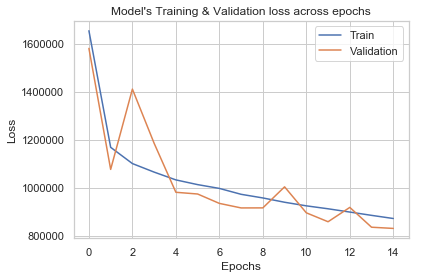

In [109]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Testing the Model Manually

In [110]:
#Manually predicting from the model, instead of using model's evaluate function
y_test["Prediction"] = model.predict(x_test)
y_test.columns = ["Actual Sales","Predicted Sales"]
print(y_test.head(10))

#Manually predicting from the model, instead of using model's evaluate function
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE :",mean_squared_error(y_test["Actual Sales"].values,y_test["Predicted Sales"].values))
print("MAE :",mean_absolute_error(y_test["Actual Sales"].values,y_test["Predicted Sales"].values))

        Actual Sales  Predicted Sales
700429          8116      9037.207031
418218          9960     10510.938477
633975          5965      6550.627441
220649          3381      4313.783203
882168          7792      7365.999512
682316          4886      4506.844238
676514          1839      2357.691650
830442          7424      7708.447754
494522             0         0.014229
73443           7833      6162.258789
MSE : 839380.287063184
MAE : 614.8591737111628
